# Agent Supervisor

### Setting up

In [1]:
import os
import getpass

def _set_if_undefined(var):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(prompt = f"Please provide your {var}")

_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

#for tracing
os.environ["LANGCHAIN_TRACING_V2"] = 'true'
os.environ["LANGCHAIN_PROJECT"] = "Multi-Agent Collaboration"

### Create Tool

In [2]:
from typing import Annotated, List, Tuple, Union

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_result = 3)
#
Python_repl_tool = PythonREPLTool()

### Helper Function

In [3]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, tools: list, system_prompt: str):
    #each agent would be given a name and a tool
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name = "messages"),
            MessagesPlaceholder(variable_name = "agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent = agent, tools = tools)
    return executor

In [4]:
#converting the output of the nodes to Human understandable Messages
def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content = result["output"], name = name)]}

### Create Agent Supervisor

In [5]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser

members = ["Researcher", "Coder", "Technical_writer"]

system_prompt = (
    "You are a supervisor tasked with managing the conversation between the following worker: {members}."
    "Given the following user request, respond with the worker to act next."
    "each worker will perform a task and would respond with their results and status. "
    "when finished respond with FINISH"
)
option = ["FINISH"] + members
function_def = {
    "name" : "route",
    "description" : "Select the next role",
    "parameters" : {
        "title": "route2Schema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enun": option},
                ],
            }
        },
        "required": ["next"],
    },
}

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name = "messages"),
        (
            "system",
            "Given the converstion above who should act next?"
            "or, should we FINISH?, select one of: {option}",
        ),
    ]
).partial(option = str(option), members = ", ".join(members))

llm = ChatOpenAI(model = "gpt-3.5-turbo")

supervisor_chain = (
    prompt
    | llm.bind_functions(functions = [function_def], function_call = "route")
    | JsonOutputFunctionsParser()
)

### Construct Graph

In [6]:
import operator
from typing import Annotated, Any, Dict, List, Optional, Sequence, TypedDict
import functools

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    next:str

#Creating our Agents
research_agent = create_agent(llm, [tavily_tool], "you are a seasoned web researcher")
research_node =functools.partial(agent_node, agent = research_agent, name = "Researcher")


code_agent = create_agent(
    llm,
    [Python_repl_tool],
    "you can generate python codes, you can refractor your codes and give tips on how to write better codes, you can also create charts using matplotlib"
)
code_node = functools.partial(agent_node, agent = code_agent, name = "Coder")

technical_writer_agent = create_agent(
    llm,
    [tavily_tool],
    "you are a world class technical writer, and documentation provider"
)
technical_writer_node = functools.partial(agent_node, agent = technical_writer_agent, name ="Technical_writer")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("Technical_writer", technical_writer_node)
workflow.add_node("supervisor", supervisor_chain)

In [7]:
for member in members:
    #workers have to report back to our supervisor
    workflow.add_edge(member, "supervisor")
conditional_map ={k: k for k in members}
conditional_map["FINISH"] = END

def next_path(x):
    return x["next"]

workflow.add_conditional_edges("supervisor", next_path, conditional_map)
#add entry point
workflow.set_entry_point("supervisor")

graph = workflow.compile()


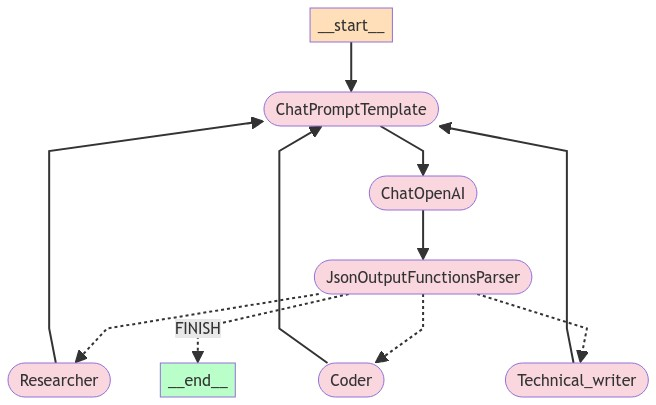

In [8]:
from IPython.display import Image, display
try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Invoke the team

In [10]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content = "Build a simple system that calculates hw much coding i need to do to get into a Bigtech, also write a documentation for the system")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Coder'}}
---


{'Coder': {'messages': [HumanMessage(content='The total coding hours required to get into the Bigtech companies (Google, Facebook, Amazon, Microsoft) is 500 hours.\n\n---\n\n## Documentation: Coding Hours Calculation System\n\n### Overview\nThe Coding Hours Calculation System is a simple tool that calculates the total number of coding hours required to get into the Bigtech companies: Google, Facebook, Amazon, and Microsoft.\n\n### Features\n1. **Bigtech Coding Hours:** The system defines the coding hours required for each Bigtech company.\n2. **Total Coding Hours Calculation:** It calculates the total coding hours required by summing up the coding hours for all Bigtech companies.\n3. **Output:** The system displays the total coding hours needed to get into all Bigtech companies.\n\n### Usage\n1. **Input:** No user input is required as the coding hours for each Bigtech company are predefined in the system.\n2. **Output:** The system outputs the total coding hours required to get into th

In [11]:
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content = "Do a simple research on Angel Mba")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Researcher'}}
---
{'Researcher': {'messages': [HumanMessage(content="I found some information related to Angel Mba:\n\n1. [Nerdwallet](https://www.nerdwallet.com/article/small-business/angel-investors-start-up-funding): The article discusses the pros and cons of angel investors, advantages of angel investors, and ways to find potential angel investors. It also mentions alternatives to angel investors such as startup business loans.\n\n2. [US News](https://www.usnews.com/education/online-education/angelo-state-university-OBUS0017/mba): Angelo State University offers an Online MBA program that can be completed in as few as 12 months for as little as $12,720.\n\n3. [Angelo State University](https://www.angelo.edu/academics/programs/business-administration-mba/): Earning an online Master of Business Administration degree at Angelo State University can help advance your career in various organizations. The professors are dedicated to helping students succeed in the 